### Problem Statement

Jamboree has helped thousands of students like you make it to top colleges abroad. Be it GMAT, GRE or SAT, their unique problem-solving methods ensure maximum scores with minimum effort.
They recently launched a feature where students/learners can come to their website and check their probability of getting into the IVY league college. This feature estimates the chances of graduate admission from an Indian perspective.
- We want to create a Linear Regression model to predict the Chance of Admission.
- We also want to explain what features are important for admission and how there are related to each other.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot

In [ ]:
link = 'https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/839/original/Jamboree_Admission.csv'

df = pd.read_csv(link)

In [ ]:
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


- Target variable is the 'Chance of Admit'
- All the other variables are features

In [ ]:
df.shape

(500, 9)

- Dataset has 500 records and 8 features and 1 Target label.

In [ ]:
#Checking the Serial No.
df['Serial No.'].shape

(500,)

In [ ]:
df['Serial No.'].value_counts().max()

1

- 'Serial No.' is just a sequential number for each record. It is a unique row identifier. This is not useful for model creation and prediction. We drop this column.

In [ ]:
df = df.drop(['Serial No.'], axis = 1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          500 non-null    int64  
 1   TOEFL Score        500 non-null    int64  
 2   University Rating  500 non-null    int64  
 3   SOP                500 non-null    float64
 4   LOR                500 non-null    float64
 5   CGPA               500 non-null    float64
 6   Research           500 non-null    int64  
 7   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 31.4 KB


- All the features and the label are in the correct data format.
- All the features above are needed for analysis and prediction.

In [ ]:
# some columns names have trainling spaces

df.columns = df.columns.str.strip()

In [ ]:
df.isna().sum()

GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

- We do not have any missing values in this dataset

In [ ]:
df.duplicated().sum()

0

- There is no duplicated records in the dataset

### Analysis


In [ ]:
df.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


- GRE score is from 290-340.
- There are 5 ratings for the University ( 1 to 5 )
- CGPA is out of 10
- Research is a Binary feature. This might indicate whether the person has done any reseach paper or not.
- Finally, target - 'Chance of Admit' seems to be a probability from 0 to 1.

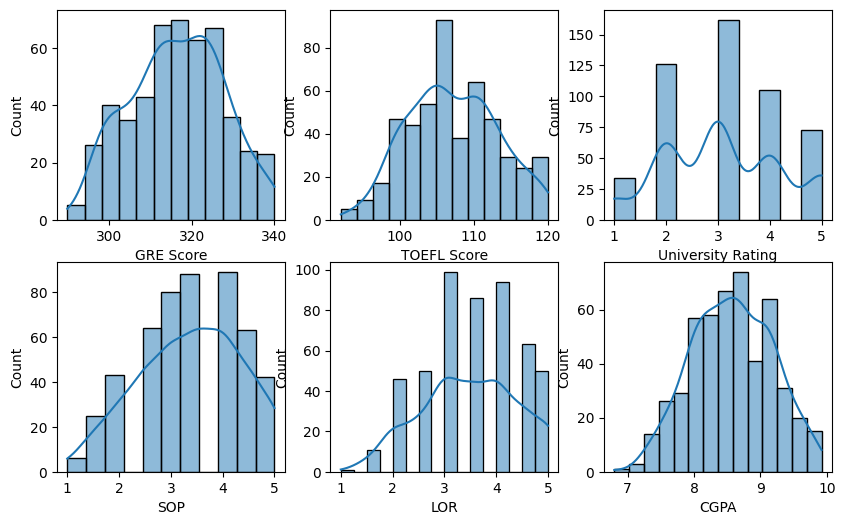

In [ ]:
fig, ax = plt.subplots(2,3, figsize = (10,6))
cols = df.columns[:-2]
for i in range(6):
  sns.histplot(data = df[cols[i]], kde = True, ax = ax[i//3][i%3])

- Except University rating, all the others seems to obey Normal Distribution.

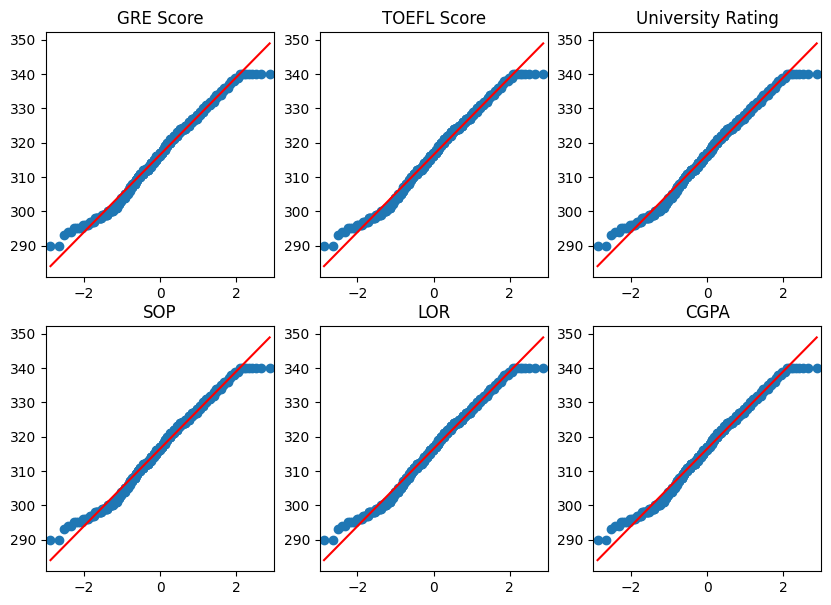

In [ ]:
# lets test using QQ plot for the normal distribution
fig, ax = plt.subplots(2,3, figsize = (10,7))
for i in range(6):
  qqplot(df[cols[0]], line = 's', ax = ax[i//3][i%3])
  ax[i//3][i%3].set_title(cols[i])
  ax[i//3][i%3].set_xlabel('')  # Remove x-label
  ax[i//3][i%3].set_ylabel('')  # Remove y-label

- From the QQ plot visual check, we can conclude that all the features follow Normal distribution. We will cite this conclusion to use StandardScaler.

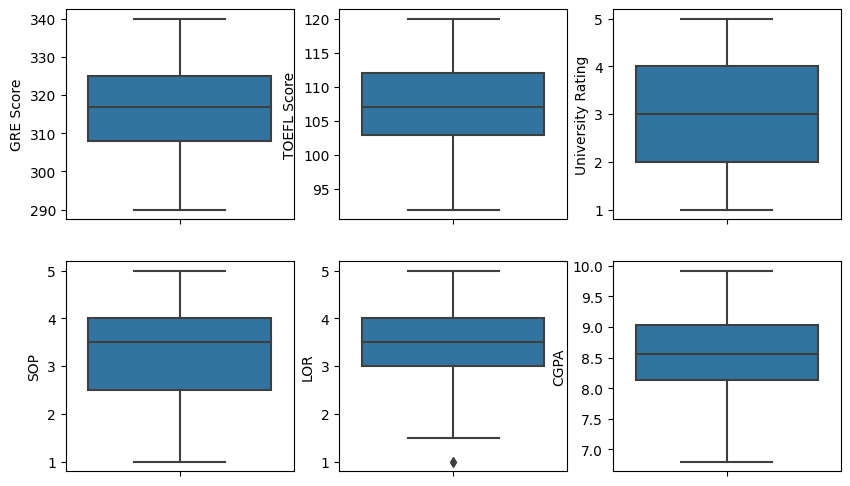

In [ ]:
# using the Box Plot to find the outliers

fig, ax = plt.subplots(2,3, figsize = (10,6))
for i in range(6):
  sns.boxplot(y = df[cols[i]], ax = ax[i//3][i%3])

In [ ]:
df['LOR'].value_counts().sort_index()

1.0     1
1.5    11
2.0    46
2.5    50
3.0    99
3.5    86
4.0    94
4.5    63
5.0    50
Name: LOR, dtype: int64

- Using the Boxplot, we can see that we have outliers for LOR.
- We have one outlier with value-1. We will change that to 1.5 (Lower Whisker value)

In [ ]:
quantile_1, quantile_3 = df['LOR'].quantile([0.25, 0.75])
lower_whisker = quantile_1 - 1.5 * (quantile_3 - quantile_1)
df.loc[df['LOR'] == 1, 'LOR'] = lower_whisker

In [ ]:
df['LOR'].value_counts().sort_index()

1.5    12
2.0    46
2.5    50
3.0    99
3.5    86
4.0    94
4.5    63
5.0    50
Name: LOR, dtype: int64

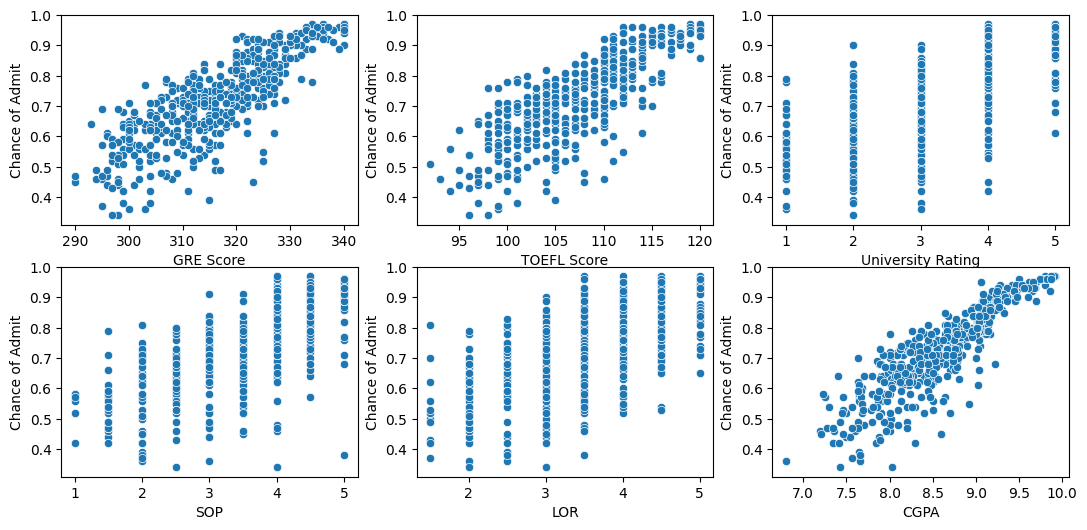

In [ ]:
fig, ax = plt.subplots(2,3, figsize = (13,6))
for i in range(6):
  sns.scatterplot(x = df[cols[i]], y = df['Chance of Admit'], ax = ax[i//3][i%3])

In [ ]:
df.corr()['Chance of Admit'].sort_values(ascending = False)

Chance of Admit      1.000000
CGPA                 0.882413
GRE Score            0.810351
TOEFL Score          0.792228
University Rating    0.690132
SOP                  0.684137
LOR                  0.644737
Research             0.545871
Name: Chance of Admit, dtype: float64

- CGPA has higher correlation to the Chance of Admit. CGPA has higher weightage to determine the Change of Admit.
- Followed by CGPA, we have GRE score abd TOEFL score.
- There is also positive correlation between other features and the target ['Chance of Admit']

<Axes: >

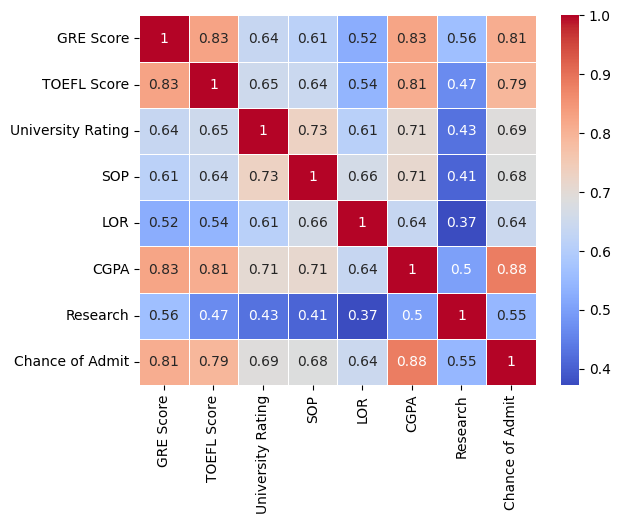

In [ ]:
sns.heatmap(df.corr(), cmap = 'coolwarm', annot = True, linewidths = 0.5)

## Linear Regression

In [ ]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error, mean_absolute_percentage_error

In [ ]:
# Splitting the data into independent features and target label

X = df.iloc[:,:-1]
y = df['Chance of Admit']
X.shape, y.shape

((500, 7), (500,))

In [ ]:
X.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA',
       'Research'],
      dtype='object')

In [ ]:
# generating train, test and validation set

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1/0.9)
print('X_train', X_train.shape)
# print('X_val', X_val.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
# print('y_val', y_val.shape)
print('y_test', y_test.shape)

X_train (375, 7)
X_test (125, 7)
y_train (375,)
y_test (125,)


In [ ]:
# normalizing the dataset using Standard Scaler
column_names = X_train.columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = column_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = column_names)

In [ ]:
def adj_r2_score(r2, d, n):
  return 1 - (1-r2)*(n-1)/(n-d-1)

In [ ]:
models = [
    ['Linear Regression :', LinearRegression()],
    ['Lasso Regression :', Lasso(alpha = 0.5)],
    ['Ridge Regression :', Ridge(alpha = 0.5)]
]
for model_name, model in models:
  print('*' * 50)
  print(model_name)
  lr_model = model
  lr_model.fit(X_train_scaled, y_train)
  r2_train = lr_model.score(X_train_scaled, y_train)
  r2_test = lr_model.score(X_test_scaled, y_test)
  print('R2-Train - ', r2_train)
  print('R2-Test - ', r2_test)
  print('Adj_R2-Test - ', adj_r2_score(r2_test, X_train_scaled.shape[1], len(X_train_scaled)))
  print('Adj_R2-Test - ', adj_r2_score(r2_test, X_test_scaled.shape[1], len(X_test_scaled)))


**************************************************
Linear Regression :
R2-Train -  0.8330784512663201
R2-Test -  0.7661965201895014
Adj_R2-Test -  0.7617370532721349
Adj_R2-Test -  0.7522082778076766
**************************************************
Lasso Regression :
R2-Train -  0.0
R2-Test -  -0.017396666496030333
Adj_R2-Test -  -0.03680205250549129
Adj_R2-Test -  -0.07826655252570736
**************************************************
Ridge Regression :
R2-Train -  0.8330768165821112
R2-Test -  0.7663886102015409
Adj_R2-Test -  0.7619328071263659
Adj_R2-Test -  0.7524118603845391


- There seems to be no significant increase in the R2 score for the Lasso and Ridge Regularisation model.
- We will continue with the Vanilla Linear Regression model for further analysis

## Statsmodel

In [ ]:
import statsmodels.api as sm

In [ ]:
X_train_scaled = sm.add_constant(X_train_scaled)

In [ ]:
model = sm.OLS(y_train.values, X_train_scaled).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     261.7
Date:                Sun, 07 Jan 2024   Prob (F-statistic):          1.91e-138
Time:                        16:13:42   Log-Likelihood:                 528.76
No. Observations:                 375   AIC:                            -1042.
Df Residuals:                     367   BIC:                            -1010.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.7175      0.00

- Since the p-value of SOP is greater than 0.05, we drop the SOP feature. We also check the co-variance using the VIF method, before dropping

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

vif = pd.DataFrame()
vif['features'] = X_train_scaled.columns
vif['VIF'] = [VIF(X_train_scaled, i) for i in range(len(X_train_scaled.columns))]
vif

,features,VIF
0,const,1.000000
1,GRE Score,4.612862
2,TOEFL Score,3.935409
3,University Rating,2.385805
4,SOP,2.785957
5,LOR,2.142199
6,CGPA,5.038431
7,Research,1.555155


- We drop the SOP column and test of VIF again

In [ ]:
X_train_scaled_new = X_train_scaled.drop('SOP', axis = 1)
vif = pd.DataFrame()
vif['features'] = X_train_scaled_new.columns
vif['VIF'] = [VIF(X_train_scaled_new, i) for i in range(len(X_train_scaled_new.columns))]
vif

,features,VIF
0,const,1.000000
1,GRE Score,4.610050
2,TOEFL Score,3.885929
3,University Rating,2.112646
4,LOR,1.973019
5,CGPA,4.841512
6,Research,1.554910


In [ ]:
model_new = sm.OLS(y_train.values, X_train_scaled_new).fit()
print(model_new.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     305.2
Date:                Sun, 07 Jan 2024   Prob (F-statistic):          1.61e-139
Time:                        16:13:42   Log-Likelihood:                 528.32
No. Observations:                 375   AIC:                            -1043.
Df Residuals:                     368   BIC:                            -1015.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.7175      0.00

In [ ]:
# Dropping SOP from the test set
X_test_scaled = sm.add_constant(X_test_scaled)
X_test_scaled_new = X_test_scaled.drop('SOP', axis = 1)

In [ ]:
pred = model_new.predict(X_test_scaled_new)

print('Mean Absolute Error: ', mean_absolute_error(y_test,pred) )
print('Root Mean Square Error: ', np.sqrt(mean_squared_error(y_test, pred)))
print('Mean Absolute Percentage Error: ', mean_absolute_percentage_error(y_test, pred))

Mean Absolute Error:  0.04679217172095983
Root Mean Square Error:  0.06197045145891519
Mean Absolute Percentage Error:  0.06996545084235442


### Mean of Residuals

In [ ]:
residuals = y_test - pred
print('Mean of Residuals: ', np.mean(residuals))

Mean of Residuals:  -0.016903793749329717


- The mean of residuals is near zero, which indicates that the residuals have no outliers

### Residual Plot - Normality

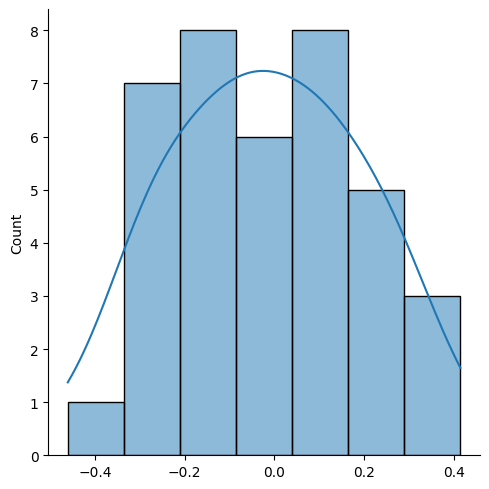

In [ ]:
sns.displot(residuals, kde = True)
plt.show()

- The residuals are normally distributed, without any outliers

### Test for Homoscedasticity

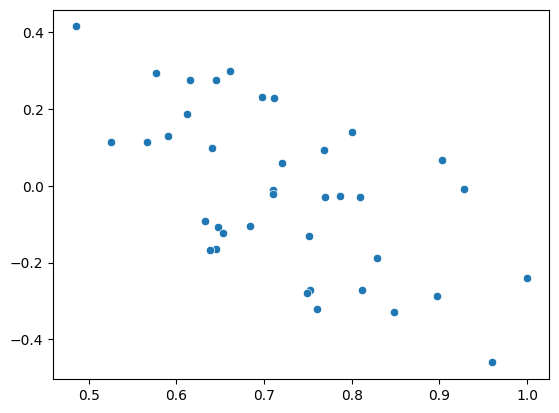

In [ ]:
sns.scatterplot(x=pred,y=residuals)
plt.show()

- The scatterplot indicates that there are no patterns in the residual vs predicted value plot, indicating there is not Heteroscedasticity.

In [ ]:
from statsmodels.stats.diagnostic import het_goldfeldquandt
gq_test = het_goldfeldquandt(y_train, X_train_scaled_new)
print(f"F statistic: {gq_test[0]}")
print(f"p-value: {gq_test[1]}")

F statistic: 1.0712971070617563
p-value: 0.32200448568694334


Null Hypothesis - The error residuals are Homoscedastic
Alternate Hypothesis - The error residuals are Heteroscedastic

Since p-value > 0.05, we fail to reject the null hypothesis.

## Inference and Business Insights

- GRE Score and TOEFL score has coefficient of 0.0206 and 0.0141 units respectively suggesting that they have high relation to the dependent variable. They are also statistically significant at the 0.05 level (p-value = 0.002 < 0.05).




- University rating is not statistically significant at the 0.05 level

- Lasso and Ridge Regressor models does not provide any imporvement in the metrics.

- There was no significant change in the metric after removing the feature 'SOP'

- The model performance can be further improved by feature engineering or hyperparameter tuning